In [1]:
import random
import torch

In [2]:
import d2l
from d2l import torch as d2l

In [3]:
hg_wells = d2l.read_time_machine()

In [4]:
hg_wells[34:39]

['that is all right said the psychologist',
 '',
 'nor having only length breadth and thickness can a cube have a',
 'real existence',
 '']

In [5]:
def tokenize(lines, type='word'):
    if type=='word':
        return [line.split() for line in lines]
    elif type=='char':
        return [list(line) for line in lines]
    else:
        return 'unknown type of token. Check definition.'

In [6]:
tokens = tokenize(hg_wells)


In [7]:
tokens[15:17][:3]

[['luxurious',
  'after',
  'dinner',
  'atmosphere',
  'when',
  'thought',
  'roams',
  'gracefully'],
 ['free',
  'of',
  'the',
  'trammels',
  'of',
  'precision',
  'and',
  'he',
  'put',
  'it',
  'to',
  'us',
  'in',
  'this']]

In [8]:
char_tokens = tokenize(hg_wells, type='char')

char_tokens[15][:5]

['l', 'u', 'x', 'u', 'r']

In [9]:
corpus  = [token for line in tokens for token in line]

In [10]:
corpus[:5]

['the', 'time', 'machine', 'by', 'h']

In [11]:
import collections

def count_corpus(tokens):
    if len(tokens)==0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [34]:
class Vocab:
    def __init__(self,tokens=None, min_freq=0,reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        
        self.counter = count_corpus(tokens)
        self._token_freqs = sorted(self.counter.items(), key=lambda x: x[1], reverse=True)
        
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_index = {token : idx for idx, token in enumerate(self.idx_to_token)}
        
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.idx_to_token:
                self.idx_to_token.append(token)
                self.token_to_index[token] = len(self.idx_to_token)-1
    
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        #recursively tries to get the individual item
        if not isinstance(tokens,(list, tuple)):
            #print(self.token_to_index.get(tokens, self.unk))
            return self.token_to_index.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def totokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.totokens(index) for index in indices]
    
    @property
    def unk(self):
        return 0
    
    @property
    def token_freqs(self):
        return self._token_freqs

In [35]:
vocab = Vocab(tokens)

#looking through functions in vocab
freq_dict = sorted(vocab.counter.items(), key=lambda x: x[1], reverse=True)[:5]

print(freq_dict)

idx_to_token = []

for token, freq in freq_dict:
    idx_to_token.append(token)

print(idx_to_token)

vocab['the'] # should call __getitem__

vocab[idx_to_token]

[('the', 2261), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816)]
['the', 'i', 'and', 'of', 'a']


[1, 2, 3, 4, 5]

In [37]:
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

In [38]:
#same thing
#vocab = d2l.Vocab(corpus)

In [39]:
#vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

As we can see, the most popular words are actually quite boring to look at. They are often referred
to as stop words and thus filtered out. Nonetheless, they still carry meaning and we will still use
them. Besides, it is quite clear that the word frequency decays rather rapidly. The 10th most frequent word is less than 1/5 as common as the most popular one. To get a better idea, we plot the
figure of the word frequency.

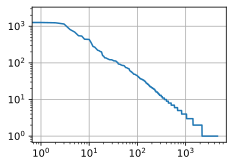

In [47]:
freqs = [freq for token, freq in vocab.token_freqs]

import matplotlib.pyplot as plt

plt.plot(freqs)
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

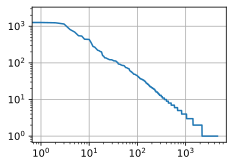

In [48]:
#same as
d2l.plot(freqs, xscale='log', yscale='log')

We are on to something quite fundamental here: the word frequency decays rapidly in a welldefined way. After dealing with the first few words as exceptions, all the remaining words roughly
follow a straight line on a log-log plot. This means that words satisfy Zipf’s law, which states that
the frequency ni of the i
th most frequent word is:

ni ∝ 1/i^a(8.3.7)
which is equivalent to
log ni = −α log i + c, (8.3.8)

where α is the exponent that characterizes the distribution and c is a constant. This should already
give us pause if we want to model words by counting statistics and smoothing. After all, we will
significantly overestimate the frequency of the tail, also known as the infrequent words. But what
about the other word combinations, such as bigrams, trigrams, and beyond?

In [49]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]

bigram_vocab = Vocab(bigram_tokens)

In [51]:
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [55]:
bigram_freq = [freq for token, freq in bigram_vocab.token_freqs]

def plot_log(freq):
    plt.plot(freq)
    plt.grid(True)
    plt.xscale('log')
    plt.yscale('log')



In [54]:
trigram_tokens = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]

trigram_vocab = Vocab(trigram_tokens)

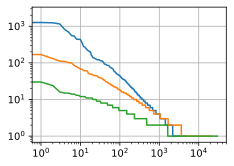

In [58]:
trigram_freq = [freq for token, freq in trigram_vocab.token_freqs]

plot_log(freqs)
plot_log(bigram_freq)
plot_log(trigram_freq)
plt.show()